In [1]:
#include("MAB_module.jl")
include("environment.jl")
include("algorithm_base.jl")
include("eps_greedy.jl")
include("rs.jl")
include("lsx.jl")
#include("meta-bandit.jl")
include("ucb1tuned.jl")

update! (generic function with 4 methods)

In [2]:
using Plots
using Statistics
#using Base.Threads

In [3]:
mutable struct MYRS <: Algorithm
    env::Environment
    actionValues::Vector{Float64}
    counts::Vector{Float64}             #numbers of selection of each arm.
    sum_rewards::Vector             #sum of an earned reward of each arm
    average::Vector
    r::Float64
    gamma::Float64
    alpha_r::Float64
    n::Float64
    opt::Bool
    test_name::String
    #constructor
    function MYRS(;env::Environment, r::Float64, gamma::Float64, alpha_r::Float64, n=0.,opt=false, test_name="")
        return new( env,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    r,
                    gamma,
                    alpha_r,
                    n,
                    opt,
                    test_name)
    end
end

In [4]:
function init!(algo::MYRS)
    init_algo!(algo)
    if algo.opt
        sorted_pro = sort(algo.env.arm_pros, rev=true)
        algo.r = (sorted_pro[1] + sorted_pro[2]) / 2
    else
        algo.r = 1.
    end
end

function select_arm(algo::MYRS)
    #return index of maximum value in the action values.
    return greedy(algo)
end

function calc_value(algo::MYRS, selected, reward)
        
    if algo.test_name == "gamma"
        algo.average[selected] = algo.sum_rewards[selected] / algo.counts[selected]
        for i=1:algo.env.arm_num
            algo.counts[i] = algo.gamma * algo.counts[i]
            algo.sum_rewards[i] = algo.gamma * algo.sum_rewards[i]
        end
        
    else
        algo.average[selected] = algo.sum_rewards[selected] / algo.counts[selected]
        #algo.r += algo.alpha_r * (algo.average[selected] - algo.r)
        #algo.r += algo.alpha_r * (algo.sum_rewards[selected] / algo.counts[selected] - algo.r)
    end
    
    if !algo.opt
        algo.r += algo.alpha_r * (algo.average[selected] - algo.r)
    end
    
    if algo.test_name == "gamma"
        for i=1:algo.env.arm_num
            algo.actionValues[i] = algo.counts[i]*(algo.average[i] - algo.r)
        end
    else
        algo.actionValues[selected] = algo.counts[selected]*(algo.average[selected] - algo.r)
    end
    
#     if f_algo(algo, selected) > 0.99
#         algo.actionValues[selected] = 2*algo.counts[selected]*(algo.average[selected] - algo.r)
#     else
#         algo.actionValues[selected] = algo.counts[selected]*(algo.average[selected] - algo.r)
#     end
   # if algo.actionValues[selected] < algo.n*(1 - algo.r)
        #algo.actionValues[selected] += (reward - algo.r) #+ algo.gamma * algo.actionValues[selected]
#     else
#      for i=1:algo.env.arm_num
#             algo.counts[i] = algo.gamma * algo.counts[i]
#      end
#     end
    #algo.actionValues[selected] = algo.gamma * algo.actionValues[selected]


    #@show algo.r selected
end

#update each variables and calc parameters for epsilon greedy algorithm
function update!(algo::MYRS)
    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    #update this experiment's current state.
    #algo.n[selected] = (reward + algo.gamma*algo.n[selected])/(1. + algo.gamma)
    algo.counts[selected] = algo.counts[selected] + 1
    algo.sum_rewards[selected] += reward

    #calculation of action value and save.
    calc_value(algo, selected, reward)
    
#     for i=1:algo.env.arm_num
#         algo.counts[i] = algo.gamma * algo.counts[i]
#     end

    #calc regret.
    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret, reward

end

#simple version of the RS Algorithm.
function simple_update!(algo::MYRS)
    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    #RS = n(E-R) <==> delta RS is only (r-R).
    algo.actionValues[selected] += reward - algo.r

    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret
end

simple_update! (generic function with 2 methods)

In [5]:
function simulation(;sim_num::Int, steps::Int, update_per::Int, arm_num=4, dynamic=false)
    #argument checking.
    if dynamic && update_per <= steps && steps % update_per != 0
        println("update number error.")
        return
    end

    update_num = div(steps, update_per)#convert(Int64, steps/update_per)
    env = Environment(arm_num)

    algo_dict = Dict()
    
    for gamma=[0.999]
        alpha = 0.0005
        #alpha = 1/(10^i)
        algo_dict["RS \\gamma=$gamma"] = MYRS(env=env, r=1., gamma=gamma, alpha_r=alpha, test_name="gamma")
    end
    algo_dict["RS opt \\gamma"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true, test_name="gamma")
    algo_dict["RS opt"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true)
#     for gamma in [0.7, 0.5, 0.3]
#         algo_dict["MYRS merge gamma=$gamma"] = MYRS(env, 1., gamma, 0.001, "merge")
#     end

    algo_dict["RS"] = RS(env)
    algo_dict["UCB1 tuned"] = UCB1(env, true)
#      for alpha in [0.6, 0.7]
#         algo_dict["LSX alpha=$alpha"] = LSX(env=env,
#                                             alpha=alpha)
#     end
#     algo_dict["LSX opt"] = LSX(env=env,
#                                         alpha=0.6,
#                                         opt=true)
#     algo_dict["LSX alpha=0.6"] = LSX(env=env,
#                                             alpha=0.6)
#     algo_dict["LSX opt gamma"] = LSX(env=env,
#                                         alpha=0.1,
#                                         model="opt",
#                                         gamma=0.999)
    
    regret_means, win_means, action_vals = Vector{}(), Vector{}(), Vector{}()
    for algorithm in values(algo_dict)
        regrets, wins = zeros(sim_num, steps), zeros(sim_num, steps)
        #action_val = Vector{}()
        for sim in 1:sim_num
            ds = rand(update_num,arm_num)
            update_env!(env, ds[1, :])
            init!(algorithm)
            regret = 0.
            
            for step in 1:steps-1
                selected, rgt, reward = update!(algorithm)

                #save each parameter.
                regret += rgt
                regrets[sim, step] = regret

                if selected == env.correct_arm
                    wins[sim, step] = 1
                end
                
                if dynamic
                    if step % update_per == 0
                        ds_idx = div(step, update_per)
                        update_env!(env, ds[ds_idx+1, :])
                        #println("<----------updated------------->")
                        if typeof(algorithm) == RS
                            update_r!(algorithm)
                        elseif typeof(algorithm) == LSX && algorithm.opt
                            algorithm.r = opt_r(algorithm.env.arm_pros)
                        elseif typeof(algorithm) == MYRS
                            if algorithm.opt
                                sorted_pro = sort(env.arm_pros, rev=true)
                                algorithm.r = (sorted_pro[1] + sorted_pro[2]) / 2
                            end
                        end
                    end
                end

            end
            if sim % 10 == 0
                print("$((sim/sim_num)*100) %")
            end
        end
        push!(regret_means, [mean(regrets[:, i]) for i=1:steps])
        push!(win_means, [mean(wins[:, i]) for i=1:steps])
        #push!(action_vals, vcat(action_val...))
        
    end
    
    println("DONE.")
    
    #@show action_vals

    graph_data = hcat(win_means...)
    time = Vector{Int}(1:steps)
    #xscale=:log

    #graph_data2 = vcat(rslist...)
    #@show size(graph_data2)
    graph_data2 = hcat(regret_means...)

    return graph_data, graph_data2, algo_dict
end

simulation (generic function with 1 method)

In [6]:
@time g1, g2, algo_dict = simulation(sim_num=1000,
                            steps=100000,
                            update_per=10000,
                            arm_num=20,
                            dynamic=true)

1.0 %2.0 %3.0 %4.0 %5.0 %6.0 %7.000000000000001 %8.0 %9.0 %10.0 %11.0 %12.0 %13.0 %14.000000000000002 %15.0 %16.0 %17.0 %18.0 %19.0 %20.0 %21.0 %22.0 %23.0 %24.0 %25.0 %26.0 %27.0 %28.000000000000004 %28.999999999999996 %30.0 %31.0 %32.0 %33.0 %34.0 %35.0 %36.0 %37.0 %38.0 %39.0 %40.0 %41.0 %42.0 %43.0 %44.0 %45.0 %46.0 %47.0 %48.0 %49.0 %50.0 %51.0 %52.0 %53.0 %54.0 %55.00000000000001 %56.00000000000001 %56.99999999999999 %57.99999999999999 %59.0 %60.0 %61.0 %62.0 %63.0 %64.0 %65.0 %66.0 %67.0 %68.0 %69.0 %70.0 %71.0 %72.0 %73.0 %74.0 %75.0 %76.0 %77.0 %78.0 %79.0 %80.0 %81.0 %82.0 %83.0 %84.0 %85.0 %86.0 %87.0 %88.0 %89.0 %90.0 %91.0 %92.0 %93.0 %94.0 %95.0 %96.0 %97.0 %98.0 %99.0 %100.0 %1.0 %2.0 %3.0 %4.0 %5.0 %6.0 %7.000000000000001 %8.0 %9.0 %10.0 %11.0 %12.0 %13.0 %14.000000000000002 %15.0 %16.0 %17.0 %18.0 %19.0 %20.0 %21.0 %22.0 %23.0 %24.0 %25.0 %26.0 %27.0 %28.000000000000004 %28.999999999999996 %30.0 %31.0 %32.0 %33.0 %34.0 %35.0 %36.0 %37.0 %38.0 %39.0 %40.0 %41.0 %42.0 %4

([0.058 0.038 … 0.053 0.058; 0.092 0.066 … 0.033 0.078; … ; 0.617 0.909 … 0.3 0.915; 0.0 0.0 … 0.0 0.0], [0.437057 0.459613 … 0.4499 0.436783; 0.779291 0.894265 … 0.91194 0.804914; … ; 6983.54 1466.36 … 12715.3 1314.17; 0.0 0.0 … 0.0 0.0], Dict{Any,Any}("RS opt"=>MYRS(Environment([0.246196, 0.970267, 0.776737, 0.933855, 0.935231, 0.300321, 0.590522, 0.440584, 0.274967, 0.602951, 0.760382, 0.291564, 0.622101, 0.122833, 0.217201, 0.382796, 0.573563, 0.504217, 0.821628, 0.421747], 20, 0.970267, 2), [-236.328, -204.279, -87.9044, -87.8409, 250.229, -87.4254, -399.522, -234.862, -86.9905, -92.5764, -515.246, -87.1211, -192.85, -91.7165, -757.439, -105.689, -230.904, -87.3845, -663.404, -87.7774], [13336.0, 2028.0, 510.0, 493.0, 10115.0, 555.0, 5291.0, 5902.0, 218.0, 879.0, 13145.0, 379.0, 9569.0, 822.0, 19426.0, 405.0, 6535.0, 229.0, 9686.0, 476.0], [12365.0, 1712.0, 394.0, 378.0, 9808.0, 437.0, 4600.0, 5342.0, 119.0, 738.0, 12356.0, 271.0, 8849.0, 685.0, 18264.0, 277.0, 6168.0, 129.0, 8489

In [16]:
# step_axis2 = [i for i=1:10:size(g2)[1]]
# graph2 = [g2[i, :] for i in step_axis2]
# graph2 = hcat(graph2...)'
# #plot(step_axis2, graph2)
# plot(step_axis2, graph2, title="Regret", label=[key for key in keys(algo_dict)])

size(graph) = (1000, 4)


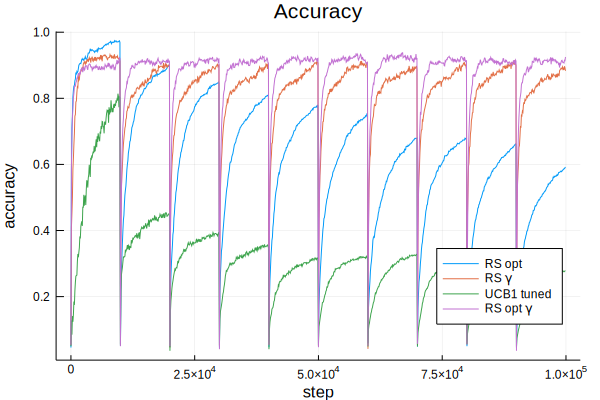

In [29]:
step_axis = [i for i=1:100:size(g1)[1]]
graph = [g1[i, :] for i in step_axis]
graph = hcat(graph...)'
graph = hcat(graph[:, 1:2], graph[:, 4:5])
@show size(graph)
#plot(1:size(g1)[1], g1, label=["RS","RS_tuned"], title="Accuracy")
#plot(step_axis, graph, title="Accuracy", label=[key for key in keys(algo_dict)], legend=:bottomright)
labels = [key for key in keys(algo_dict)]
labels[2] = "RS \\gamma"
labels = vcat(labels[1:2], labels[4:5])
plot(step_axis, graph, title="Accuracy", label=labels, xlabel="step",ylabel="accuracy", legend=:bottomright)

In [3]:
using CSV
using DataFrames
include("data_save.jl")

UndefVarError: UndefVarError: plot not defined

In [ ]:
save_csv(data=g2, file_name="./exp_data/sync_non_steady_regret_1K_100K.csv", labels=labels)